# Tried-and-True: The Titanic Dataset

I've spent this Summer of 2020 primarily focused with my work at the UCSD Department of Cognitive Science and participating in the Facebook Data Challenge. On top of that, I've been able to do lots of self-studying in the realm of statistics and business to improve my testing and product-sense. 

I wanted to put out a quick project for fun meanwhile I continue my work, so I thought I'd check out the Titanic dataset. The Titanic dataset is often toughted as a very begginer-friendly data science project. While this obviously lacks impact, I thought it'd be a fun way to spend a Sunday, meanwhile I finish up my projects in my professional work!

![](https://www.history.com/.image/ar_16:9%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cg_faces:center%2Cq_auto:good%2Cw_768/MTU3OTIzNTgwNjg3NDI3MjE4/women-and-children-first-on-sinking-ships-its-every-man-for-himselfs-featured-photo.jpg)

### The Scene

On April 12th, 1912, the Titanic set out on its maiden voyage from Southampton England, having been completed just two weeks prior. Hype had been surrounding the ship during its 2-year long construction and people were eager to finally board the ship. The Titanic promised an unmatched level of luxury, having been equipped with some of the finest amenities available during the early 20th century. Third class cabins were comparable to the upper class cabins in other, less renowned ships; 1st and 2nd class cabins in a league of their own. With a stop in France, Ireland, and New York, the Titanic was the best way to travel *in style*.

The Winter of 1911-1912 had been one of the warmest on record at the time, which resulted in a lot more drifting ice than usual. It was a dangerous time to set sail, but with pressures rising and competing lines such as Cunard hot on the Titanic's tail, the journey to New York had to go on. Given the hype around the Titanic's formidable engineering, many thought it was "practically unsinkable". Despite its size, the Titanic's creators boasted about how it could turn on a dime. These claims were put to the test when the ship miraculously avoided impact with the SS New York on its journey to Cherbourg, France. At the time, it was a testament to the Titanics superior engineering; today, it's closer to a bad omen.

![](https://vignette.wikia.nocookie.net/titanic/images/d/db/14_titanic_new_york_oceanic.jpg/revision/latest?cb=20180902183429)

On April 14th, just two days after embarking, the Titanic made impact with a lone iceberg that gashed the lower decks of the unsinkable ship. 7 tons of lethally cold ice water flooded the boiler rooms and the lungs of crew members within it. In just under three hours, the seas of the Atlantic engulfed the Titanic, taking with it the lives of 1500 men, women, and children that boarded the unsinkable ship.

### Our Goal

But was death evenly distributed? Only 1/3 of the passengers aboard the ship survived, who were they? Was it just sheer luck, or was something else at play? There has always been the idea that "women and children" will be saved first, but did this ideology live on as chaos ensued in the Titanics final moments?

Here, we aim to investigate the matter and see what attributes made passengers more likely to survive, and if such patterns even exist. We thus have two goals. First, a hypothesis.

H<sub>0</sub>: Men and Women were just as likely to survive the Titanic. <br>
H<sub>a</sub>: Men and Women differed in their likelihood of survival.

Second, if we can identify attributes that predict survival, then we should attempt to predict the survival of passengers based on these attributes. In a real word scenario, we would want a model with few false negatives, as a false negative would suggest a person who is at risk-of death would not be labeled as such. This is highly fatal and we cannot afford such errors, so they should minimized in our model. Thus models will be graded primarily on recall and F1 score.


### Cleaning and Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

import pandasql

#highly recommend pandasql! let's you manipulate pandas dataframes using sql queries
sql = lambda q: pandasql.sqldf(q, globals())

In [2]:
df = pd.read_csv('train.csv')

In [3]:
print('Duplicate Rows')
df.duplicated().value_counts()

Duplicate Rows


False    891
dtype: int64

In [4]:
#dropping directly identifiable info
df.drop(columns = ['PassengerId', 'Name'], inplace = True)

In [5]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.shape

(891, 10)

Before we start with EDA, we should clean this data up a bit more and investigate any columns with null values.

In [7]:
#checking if any columns have null values, and how many
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

There are many null values in the Age and Cabin columns. I will investigate both to see how to best handle them, starting with age.

In [8]:
#df containing rows with a null value in the age column
null_age_df = df.loc[df['Age'].isnull()]

[Text(0, 0, 'Died'), Text(0, 0, 'Survived')]

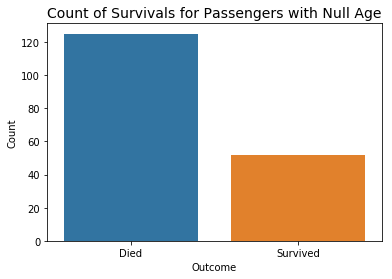

In [9]:
plt.title('Count of Survivals for Passengers with Null Age', size = 14)

g = sns.countplot(null_age_df['Survived'])

plt.ylabel('Count', size = 10)
plt.xlabel('Outcome', size = 10)

g.set_xticklabels(['Died', 'Survived'])

Most of these passengers seemed to have died aboard the Titanic. We should further segment these passengers by class to investigate further.

Text(0, 0.5, 'Count')

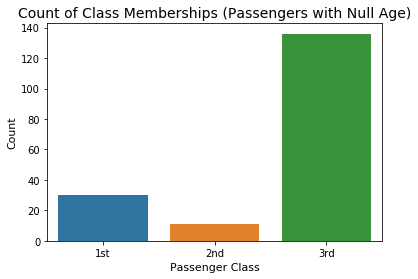

In [10]:
plt.title('Count of Class Memberships (Passengers with Null Age)', size = 14)

g = sns.countplot(null_age_df['Pclass'])

g.set_xticklabels(['1st', '2nd', '3rd'])

plt.xlabel('Passenger Class', size = 11)
plt.ylabel('Count', size = 11)

This brief inspection shows that the majority of the  passengers with null age information were in 3rd class. Our previous plot also showed that the majority of passengers with null-age also did not survive. How does this compare to the data set at large?

In [11]:
#proportion of null-age passengers that survived vs. died
nullage_survival_proportion = null_age_df['Survived'].value_counts(normalize = True).reset_index()

#proportion of all other passengers that survived vs. died
nonnull_age_df = df.loc[~df['Age'].isnull()]
df_survival_proportion = nonnull_age_df['Survived'].value_counts(normalize = True).reset_index()

In [12]:
print('Null Age Survival Propotions')
nullage_survival_proportion

Null Age Survival Propotions


,index,Survived
0,0,0.706215
1,1,0.293785


In [13]:
print('Non-Null Age Survival Proportions')
df_survival_proportion

Non-Null Age Survival Proportions


,index,Survived
0,0,0.593838
1,1,0.406162


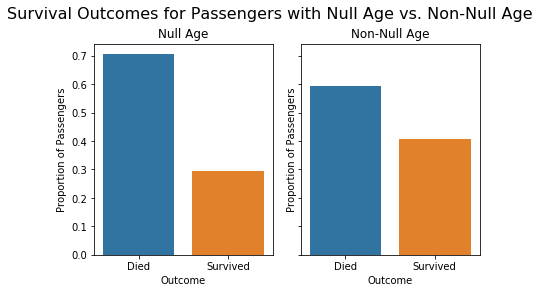

In [14]:
fig, axs = plt.subplots(1, 2, sharey = True, constrained_layout = True)

fig.suptitle('Survival Outcomes for Passengers with Null Age vs. Non-Null Age', fontsize=16)

sns.barplot(data = nullage_survival_proportion, x = 'index', y= 'Survived', ax = axs[0])
sns.barplot(data = df_survival_proportion, x = 'index', y= 'Survived', ax = axs[1])

axs[0].set_title('Null Age')
axs[0].set_xlabel('Outcome')
axs[0].set_ylabel('Proportion of Passengers')
axs[0].set_xticklabels(['Died', 'Survived'])

axs[1].set_title('Non-Null Age')
axs[1].set_xlabel('Outcome')
axs[1].set_ylabel('Proportion of Passengers')
axs[1].set_xticklabels(['Died', 'Survived'])



plt.show()

It seems like passengers that did not survive are disporportionately represented as having null in their age column. Given that information, it seems like we should hold on to those individuals with null age, as they will be useful in making our prediction. Models such as Naive-Bayes and Random Forests are robust to missing values. However, in order to avoid boxing ourselves in, we can impute these missing values using the mean, median, or mode. Before we decide, let's get a better idea of how age is distributed within this table. Additionally, we can generate appropriate ages based on other information, such as identifiers that may signal if the passanger was a child or not. This would be useful in the case that children were evacuated first, and thus were more likely to survive.

In [15]:
#Descriptive statistics of Age column
nonnull_age_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Mean of 29.69, with a standard deviation of 14.52. How does the distribution look?

C:\Users\BALTHASAR - 02\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


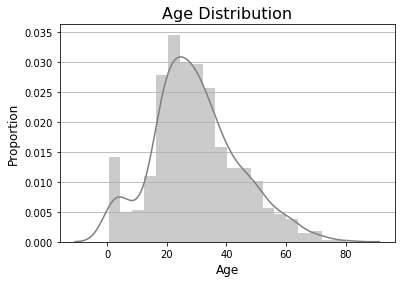

In [16]:
plt.title('Age Distribution', size = 16)

sns.distplot(nonnull_age_df['Age'], color = 'tab:grey')

plt.xlabel('Age', size = 12)
plt.ylabel('Proportion', size = 12)

plt.grid(axis = 'y')

In [17]:
print('Mode Age:', nonnull_age_df['Age'].mode()[0])

Mode Age: 24.0


In [18]:
print('Median Age:', nonnull_age_df['Age'].median())

Median Age: 28.0


Is there any differences between passenger classes?

Text(0.04, 0.5, 'Proportion')

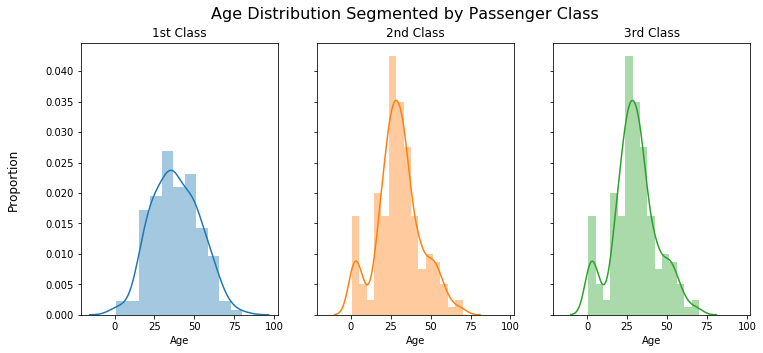

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (12,5), sharex = True, sharey = True)

fig.suptitle('Age Distribution Segmented by Passenger Class', size = 16)

sns.distplot(nonnull_age_df['Age'].loc[nonnull_age_df['Pclass'] == 1], color = 'tab:blue', ax = axs[0])
sns.distplot(nonnull_age_df['Age'].loc[nonnull_age_df['Pclass'] == 2], color = 'tab:orange', ax = axs[1])
sns.distplot(nonnull_age_df['Age'].loc[nonnull_age_df['Pclass'] == 2], color = 'tab:green', ax = axs[2])

axs[0].set_title('1st Class')
axs[1].set_title('2nd Class')
axs[2].set_title('3rd Class')

fig.text(0.04, 0.5, 'Proportion', va='center', rotation='vertical', size = 12)

First class passengers seem to be a bit older on average. Second and Third class passengers both seem to have a spike at the lower end of the age distribution. This of course must mean children aboard the ship. To get a better estimate for the childrens mean age, then we should segment this data further. Children are most likely to be traveling with parents, thus their 'Parch' column should have a value greater than 0.

Text(0.04, 0.5, 'Proportion')

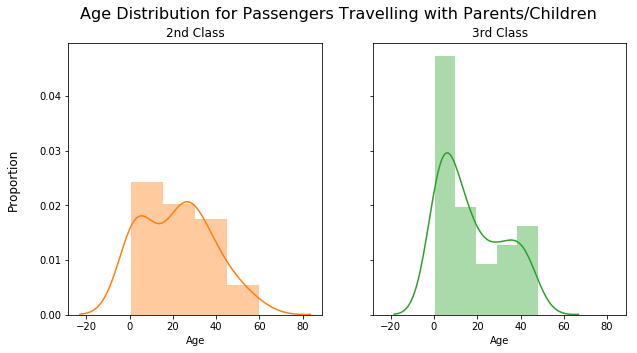

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)

fig.suptitle('Age Distribution for Passengers Travelling with Parents/Children', size = 16)

sns.distplot(nonnull_age_df['Age'].loc[(nonnull_age_df['Pclass'] == 2) & (nonnull_age_df['Parch'] > 0)],
             color = 'tab:orange',
             ax = axs[0])
sns.distplot(nonnull_age_df['Age'].loc[(nonnull_age_df['Pclass'] == 3) & (nonnull_age_df['Parch'] > 0)],
             color = 'tab:green',
             ax = axs[1])

axs[0].set_title('2nd Class')

axs[1].set_title('3rd Class')

fig.text(0.04, 0.5, 'Proportion', va='center', rotation='vertical', size = 12)

This is a much better representation of who these passengers are. With second class passengers, we can get away with imputing their values with the mean. But for passengers in third class, it seems like a mode may be more appropriate due to the heavy skew of the distribution.

It's important to note that we will inevitably be grouping some parents into the 3rd passenger bunch, due to the fact that this data uses the same column to denote if a passenger had a parent OR a child onboard. Of course, there seems to be many cases in which the number of children outweighs the number of parents. But as the data shows, a person is much more likely to be a child than a parent whenever the Parch column is greater than 0.

In [21]:
print('Second Class Mean (Passengers with a parent or child)')
nonnull_age_df['Age'].loc[(nonnull_age_df['Pclass'] == 2) & (nonnull_age_df['Parch'] > 0)].describe()

Second Class Mean (Passengers with a parent or child)


count    50.000000
mean     21.996600
std      16.229575
min       0.670000
25%       5.250000
50%      24.000000
75%      33.000000
max      60.000000
Name: Age, dtype: float64

The mean is 21.996 for 2nd class passengers with a parent or child, we will round this up to 22.

In [22]:
print('Third Class Mode (Passengers with a parent or child):',
     nonnull_age_df['Age'].loc[(nonnull_age_df['Pclass'] == 3) & (nonnull_age_df['Parch'] > 0)].mode()[0])

Third Class Mode (Passengers with a parent or child): 9.0


Mode age for third class passengers with a parent or child is 9 years old.

Now we can get better estimates for other passengers.

In [23]:
print('Description of 1st class family-less passenger age.')
nonnull_age_df['Age'].loc[(nonnull_age_df['Pclass'] == 1) & (nonnull_age_df['Parch'] == 0)].describe()

Description of 1st class family-less passenger age.


count    134.000000
mean      39.906716
std       13.394838
min       16.000000
25%       30.000000
50%       38.000000
75%       49.000000
max       80.000000
Name: Age, dtype: float64

The mean age for 1st-class passengers without parents or children aboard is 39.9, we will round this up to 40.

In [24]:
print('Description of 2nd class family-less passenger age.')
nonnull_age_df['Age'].loc[(nonnull_age_df['Pclass'] == 2) & (nonnull_age_df['Parch'] == 0)].describe()

Description of 2nd class family-less passenger age.


count    123.000000
mean      33.081301
std       11.609312
min       14.000000
25%       25.000000
50%       30.000000
75%       39.000000
max       70.000000
Name: Age, dtype: float64

Second class family-less passengers will be given a 33.

In [25]:
print('Description of 3rd class family-less passenger age.')
nonnull_age_df['Age'].loc[(nonnull_age_df['Pclass'] == 3) & (nonnull_age_df['Parch'] == 0)].describe()

Description of 3rd class family-less passenger age.


count    264.000000
mean      27.835227
std       10.460696
min        5.000000
25%       21.000000
50%       25.500000
75%       32.000000
max       74.000000
Name: Age, dtype: float64

3rd class family-less passengers will receive a 28 for their age (rounded up from 27).

In [26]:
#filling in age values for people with null age
#using age values we have just identified for the relevant segments
#if the age column is not null for a certain passenger, nothing is changed
df['Age'] = sql('''
                SELECT (
                        CASE 
                             WHEN Age IS NULL AND (Pclass = 1) THEN 40
                             WHEN Age IS NULL AND (Pclass = 2) AND (Parch = 0) THEN 33
                             WHEN Age IS NULL AND (Pclass = 2) AND (Parch > 0) THEN 22
                             WHEN Age IS NULL AND (Pclass = 3) AND (Parch = 0) THEN 27
                             WHEN Age IS NULL AND (Pclass = 3) AND (Parch > 0) THEN 9
                             ELSE Age
                        END
                        )
                FROM df''')

In [27]:
#ensuring no nul values remain
df['Age'].isnull().sum()

0

Now we can get started on investigating the Cabin column.

The cabin column actually contains very specific info, indicating the exact cabin that a person was assigned to. This on its own is not useful, but given our limited information on this column it might be useful to find out if theres is something meaningful to these null values. 

To better investigate that, I will replace the values within the Cabin column with 0 or 1. 0 indicates that there is no cabin information, and 1 indicates that there is. This will open doors for us to do correlatinal analysis and some other deeper dives.

In [28]:
#replacing cabin column values, indicating if the column is null or not
df['Cabin'] = sql('''
                  SELECT (CASE WHEN CABIN IS NULL THEN FALSE
                               ELSE TRUE 
                          END)
                  FROM df['Cabin']''')

In [29]:
#checking if reassignmnet worked
df['Cabin'].value_counts()

0    687
1    204
Name: Cabin, dtype: int64

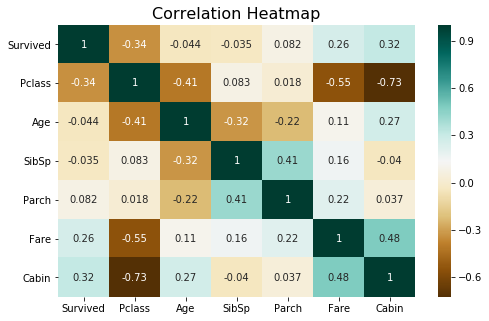

In [30]:
#plotting correlation heatmap
plt.figure(figsize = (8,5))
plt.title('Correlation Heatmap', size = 16)
c = df.corr()

sns.heatmap(c, cmap = 'BrBG', annot = True)

There is a strong negative correlation with Pclass, a moderately positive correlation with Fare, a weaker correlation with Survived. The relationship with Fare won't tell us much, as it's likely a product of the strong relationship with Pclass. So we will begin with Pclass followed by Survived.

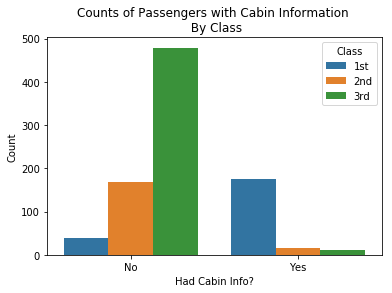

In [31]:
plt.title('Counts of Passengers with Cabin Information \n By Class')

g = sns.countplot(df['Cabin'], hue = df['Pclass'])

plt.xlabel('Had Cabin Info?')

g.set_xticklabels(['No', 'Yes'])

plt.ylabel('Count')

plt.legend(title = 'Class', labels = ['1st', '2nd', '3rd'])

The vast majority of people in this data set did not have cabin information. Most of them also happened to be in third class, but we should keep in mind that most people aboard the Titanic in general were in third clas. However, those that did have cabin info were most often in 1st class. To get a better idea of those differences we should look at what proportion of passengers have cabin information by class.

In [32]:
#getting proportions of people with cabin info grouped by class
cabin_proportions_df = sql('''
                        SELECT Pclass, CABIN, (1 - CABIN) AS NO_CABIN
                        FROM (SELECT Pclass, AVG(CASE WHEN Cabin = 0 THEN 0 ELSE 1 END) AS CABIN
                              FROM df
                              GROUP BY 1)
                        ''')

[Text(0, 0, '1st'), Text(0, 0, '2nd'), Text(0, 0, '3rd')]

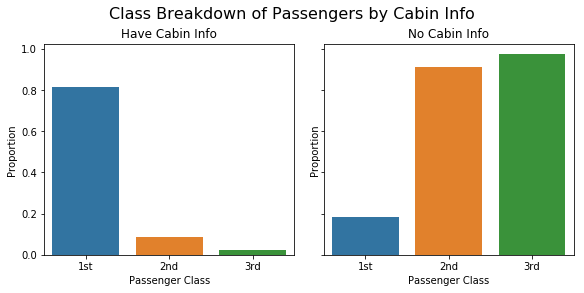

In [33]:
fig, axs = plt.subplots(1, 2, figsize = (8,4), sharex = True, sharey = True, constrained_layout = True)

fig.suptitle('Class Breakdown of Passengers by Cabin Info', size = 16)

sns.barplot(cabin_proportions_df['Pclass'], cabin_proportions_df['CABIN'], ax = axs[0])
sns.barplot(cabin_proportions_df['Pclass'], cabin_proportions_df['NO_CABIN'], ax = axs[1])

axs[0].set_title('Have Cabin Info')
axs[0].set_xlabel('Passenger Class')
axs[0].set_ylabel('Proportion')
axs[0].set_xticklabels(['1st', '2nd', '3rd'])

axs[1].set_title('No Cabin Info')
axs[1].set_xlabel('Passenger Class')
axs[1].set_ylabel('Proportion')
axs[1].set_xticklabels(['1st', '2nd', '3rd'])

Over 95% of passengers in 3rd class lack passenger information. Similarly, over 90% of 2nd class passengers lack that same information. The only passengers who consistently have cabin info are passengers in 1st class.

A 3rd class passenger could have been housed on one of four decks: D, E, F, or G deck. Their cabins were located in unfavorable areas of the ship, such as near boiler rooms or noise engines. In fact, G-deck was completely flooded within 10 minutes of collision with the iceberg; F-deck followed shortly after.

Passengers in 2nd class were housed between D and F deck.

While the correlation between survival and cabin info was weak, it may be worth looking at this discrepancy as a result of survival, meaning if the passenger did not survive, then their cabin data was not recorded.

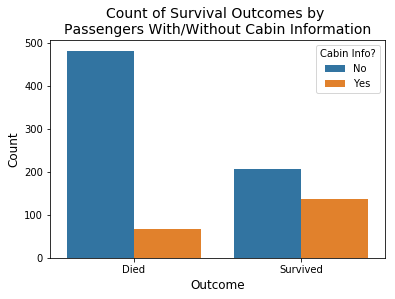

In [34]:
plt.title('Count of Survival Outcomes by \nPassengers With/Without Cabin Information', size = 14)

g = sns.countplot(df['Survived'], hue = df['Cabin'])

g.set_xticklabels(['Died', 'Survived'])

plt.xlabel('Outcome', size = 12)
plt.ylabel('Count', size = 12)

plt.legend(title = 'Cabin Info?', labels = ['No', 'Yes'])

In [35]:
print('Death Count: {} \nSurvivor Count: {}'.format(df['Survived'].value_counts()[0], 
                                                    df['Survived'].value_counts()[1]))


Death Count: 549 
Survivor Count: 342


In [36]:
print('No Cabin-Info Count: {} \nHad Cabin-Info Count: {}'.format(df['Cabin'].value_counts()[0], 
                                                                  df['Cabin'].value_counts()[1]))

No Cabin-Info Count: 687 
Had Cabin-Info Count: 204


There is not a perfect line-up between having cabin info and surviving. Judging from the raw counts of the values, it seems like 3rd class passangers were just less likely to have their cabin info taken. While this does somewhat line up with class and survival, the relationship is not very strong. This column will introduce more noise into our final model than anything, so this column should be dropped.

In [37]:
df.drop(columns = ['Cabin'], inplace = True)

Now I want to better understand the Ticket column.

In [38]:
df['Ticket'].nunique()

681

Tickets do not seem to be entirely unique.

In [39]:
df['Ticket'].value_counts()

1601            7
CA. 2343        7
347082          7
3101295         6
347088          6
CA 2144         6
382652          5
S.O.C. 14879    5
2666            4
LINE            4
19950           4
113781          4
17421           4
W./C. 6608      4
347077          4
113760          4
4133            4
PC 17757        4
349909          4
C.A. 34651      3
C.A. 31921      3
248727          3
110413          3
230080          3
345773          3
347742          3
PC 17755        3
35273           3
24160           3
239853          3
               ..
27267           1
349225          1
229236          1
111427          1
392092          1
7598            1
113509          1
33638           1
2620            1
349228          1
A.5. 18509      1
363294          1
347068          1
374910          1
113028          1
347087          1
C 7077          1
19952           1
C.A. 33595      1
244310          1
2683            1
36568           1
3460            1
350052          1
28213     

In [40]:
#checking a random observed ticket
df.loc[df['Ticket'] == '347082']

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
13,0,3,male,39.0,1,5,347082,31.275,S
119,0,3,female,2.0,4,2,347082,31.275,S
541,0,3,female,9.0,4,2,347082,31.275,S
542,0,3,female,11.0,4,2,347082,31.275,S
610,0,3,female,39.0,1,5,347082,31.275,S
813,0,3,female,6.0,4,2,347082,31.275,S
850,0,3,male,4.0,4,2,347082,31.275,S


Seems like tickets get grouped up by family. We won't be needing this column or Fare, as the two are directly related. Both are likely better predicted with Pclass. These columns would just introduce more noise to the model.

But this does beg the question: do family's have a better survival rate than single riders? This is something we will answer during EDA.

In [41]:
df.drop(columns = ['Ticket', 'Fare'], inplace = True)

In [42]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


Now that we have sufficiently cleaned our data and investigated null values, we can continue with exploratory data analysis.

### EDA

First I want to start with some low hanging fruit by getting an idea for the survival rate under a couple of different segmentations. Particularly by Class, Sex, Point of Embarkment, and Age. 

Additionally, I aim to investigate if families had a better survival rate than single riders. If such a relationship was found, then we could engineer a new feature that could more easily denote this attribute. Lastly, I want to investigate if merely having a sibling or spouse onboard led to better survival outcomes.

#### Passenger Class

In [43]:
#getting survival outcome proportions grouped by passenger class
class_proportions = (df['Survived'].groupby(df['Pclass']) #grouping
                                 .value_counts(normalize = True) #calculating proportion
                                 .rename('proportion') #renaming resulting column for compatibility with reset_index
                                 .reset_index()) #turning result into a dataframe for easy visualization

In [44]:
class_proportions

,Pclass,Survived,proportion
0,1,1,0.629630
1,1,0,0.370370
2,2,0,0.527174
3,2,1,0.472826
4,3,0,0.757637
5,3,1,0.242363


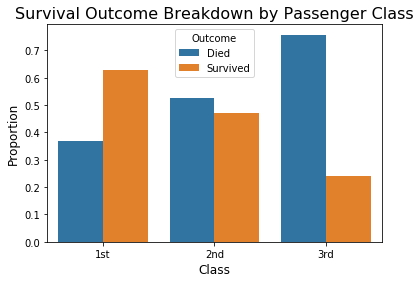

In [45]:
plt.title('Survival Outcome Breakdown by Passenger Class', size = 16)

g = sns.barplot(x = 'Pclass', y = 'proportion', data = class_proportions , hue = 'Survived')

plt.xlabel('Class', size = 12)
plt.ylabel('Proportion', size = 12)

g.set_xticklabels(['1st', '2nd', '3rd'])

h, l = g.get_legend_handles_labels()

g.legend(h, ['Died', 'Survived'],  title = 'Outcome')

3rd class passengers saw the highest death rate, while 1st class passengers saw the highest survival rate. 2nd class passengers saw more deaths, but nearly as many survivals as well. This feature should definitely be included in the model.

#### Gender
We should understand if gender affected survival outcomes aboard the Titanic.

In [46]:
#proportion of survival outcomes broken down by gender
sex_proportions = (df['Survived'].groupby(df['Sex'])
                            .value_counts(normalize = True)
                            .rename('proportion')
                            .reset_index())

In [47]:
sex_proportions

,Sex,Survived,proportion
0,female,1,0.742038
1,female,0,0.257962
2,male,0,0.811092
3,male,1,0.188908


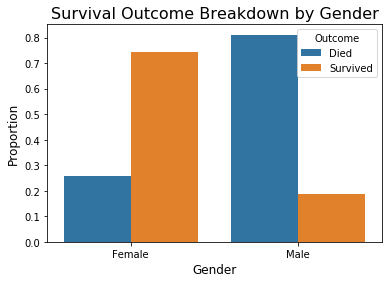

In [48]:
plt.title('Survival Outcome Breakdown by Gender', size = 16)

g = sns.barplot(x = 'Sex', y = 'proportion', data = sex_proportions , hue = 'Survived')

plt.xlabel('Gender', size = 12)
plt.ylabel('Proportion', size = 12)

g.set_xticklabels(['Female', 'Male'])

h, l = g.get_legend_handles_labels()

g.legend(h, ['Died', 'Survived'],  title = 'Outcome')

Women saw a significantly higher survival rate than men. What were the ratios for this discrepancy?

In [49]:
#geting male and female death rate
female_death_rate = sex_proportions.iloc[1, 2]/sex_proportions.iloc[0, 2]
male_death_rate = sex_proportions.iloc[2, 2]/sex_proportions.iloc[3,2]

#dividing male death rate by female death rate to get ratio between the two
male_death_rate/female_death_rate

12.3506625891947

In [50]:
print('Male-to-Female death ratio: ', 
      str(int(male_death_rate/female_death_rate)) + ':1')

Male-to-Female death ratio:  12:1


On the Titanic, for every woman that died, 12 men died (12.35 unrounded).

We should test the significance of this difference using Chi-Square as it handles categorical data and will work well to tell us if these two groups differ significantly. From there, we will measure the magnitude of this difference using a measure of Phi.

In [51]:
#temp table for easy reference of our counts
df.groupby(['Sex', 'Survived']).size()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64

Chi2_contingency is useful in that we only have to provide observed frequencies in the form of a contingency table. This test is testing our hypothesis of independence between the observed frequencies we provide. Expected frquencies are then returned using the marginal sums under the assumption of independence. Then we can get the size of the effect using Phi:

![](https://i1.wp.com/www.real-statistics.com/wp-content/uploads/2012/12/phi-effect-size.png)

To get Phi, we only have to divide our chi-square by the sample size and take the square root of the quotient. A phi of 0.1 is considered a small effect, 0.3 a medium effect, and phi over 0.5 are considered large effects.

In [52]:
#running chi square test for family membership and survival outcomes
def chi_2x2(obs):
    
    chi, p, dof, expected = chi2_contingency(obs)

    phi = np.sqrt(chi/sum(obs.ravel()))
    
    print('Chi-Square Test Statistic:',chi)
    print('P-Value:', p)
    print('Significant at Alpha = 0.05?:', p < 0.05)
    print('\n')
    print('Expected Frequencies:')
    print(expected)
    print('\n')
    print('Observed Frequencies:')
    print(obs)
    print('\n')
    print('Phi Effect Size:', phi)

In [53]:
#array of our observations
obs_sex = np.array([[81, 233], [468, 109]])

In [54]:
print('CHI-SQUARE FOR GENDER AND SURVIVAL OUTCOME')
chi_2x2(obs_sex)

CHI-SQUARE FOR GENDER AND SURVIVAL OUTCOME
Chi-Square Test Statistic: 260.71702016732104
P-Value: 1.1973570627755645e-58
Significant at Alpha = 0.05?: True


Expected Frequencies:
[[193.47474747 120.52525253]
 [355.52525253 221.47474747]]


Observed Frequencies:
[[ 81 233]
 [468 109]]


Phi Effect Size: 0.5409359434469282


The difference is highly significant and the effect size is quite large. We can say with confidence that women were more likely to survive than men on the Titanic. This will be an important feature to include in our model.

Referring back to our earlier hypothesis on genders effect on survival outcome, with these results we can reject H<sub>0</sub> in favor of the alternative hypothesis:

H<sub>a</sub>: Men and Women differed in their likelihood for survival.

#### Point of Embarkment
Next we should investigate the point of embarkment column to see if relationships exist. Perhaps certain types of passangers boarded at a particular stop that affected their survival outcome?

In [55]:
#getting survival outcome proportions grouped by point of embarkment
embarked_proportions = (df['Survived'].groupby(df['Embarked'])
                                      .value_counts(normalize = True)
                                      .rename('proportion')
                                      .reset_index())

In [56]:
embarked_proportions

,Embarked,Survived,proportion
0,C,1,0.553571
1,C,0,0.446429
2,Q,0,0.610390
3,Q,1,0.389610
4,S,0,0.663043
5,S,1,0.336957


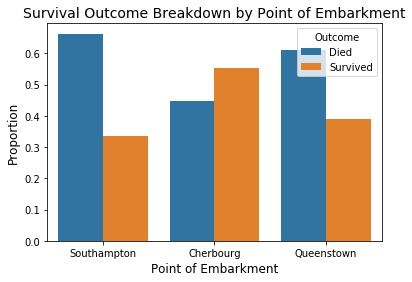

In [57]:
plt.title('Survival Outcome Breakdown by Point of Embarkment', size = 14)

g = sns.barplot(x = 'Embarked', y = 'proportion', 
                data = embarked_proportions , 
                hue = 'Survived',
                order = ['S', 'C', 'Q'])

plt.xlabel('Point of Embarkment', size = 12)
plt.ylabel('Proportion', size = 12)

g.set_xticklabels(['Southampton', 'Cherbourg', 'Queenstown'])

h, l = g.get_legend_handles_labels()

g.legend(h, ['Died', 'Survived'],  title = 'Outcome')

Passengers coming from Queenstown or Southampton saw higher death rates than those coming from Cherbourg. In fact, Cherbourg passengers had a slightly higher proportion of survivors.

Point of embarkment alone cannot explain this, so more investigation is necessary. As we saw earlier, class seemed to be highly associated with a passengers survival. Thus we can begin with comparing the class-composition of each embarkment point.

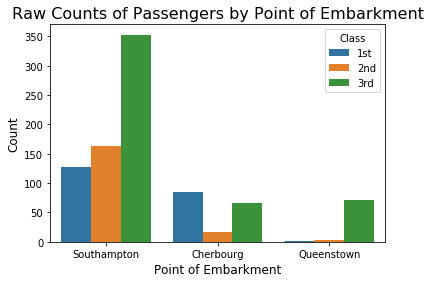

In [58]:
plt.title('Raw Counts of Passengers by Point of Embarkment', size = 16)

g = sns.countplot('Embarked', data = df, hue = 'Pclass', order = ['S', 'C', 'Q'])

plt.xlabel('Point of Embarkment', size = 12)
plt.ylabel('Count', size = 12)

g.set_xticklabels(['Southampton', 'Cherbourg', 'Queenstown'])

g.legend(title = 'Class', labels = ['1st', '2nd', '3rd'])

Most passengers boarded at Southampton, and Cherbourg saw a higher count of 1st class passengers. Queenstown saw primarily 3rd class passengers. What was the proportional breakdown of class for each embarkment point?

In [59]:
embarked_classes = (df['Pclass'].groupby(df['Embarked'])
                                      .value_counts(normalize = True)
                                      .rename('proportion')
                                      .reset_index())

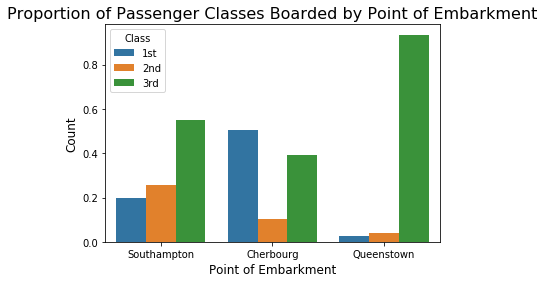

In [60]:
plt.title('Proportion of Passenger Classes Boarded by Point of Embarkment', size = 16)

g = sns.barplot(x = 'Embarked', y = 'proportion', data = embarked_classes, hue = 'Pclass', order = ['S', 'C', 'Q'])


plt.xlabel('Point of Embarkment', size = 12)
plt.ylabel('Count', size = 12)

h, l = g.get_legend_handles_labels()

g.set_xticklabels(['Southampton', 'Cherbourg', 'Queenstown'])

g.legend(h, ['1st', '2nd', '3rd'], title = 'Class')

Southampton saw primarily 3rd class passengers, but with a few 1st and 2nd class passengers as well. Cherbourg saw a high proportion of 1st class passenger with a comparable amount of 3rd class passengers. Lastly, Queenstown saw 3rd class passengers the ship almost exclusively.

To recap: Southampton is actually where the brunt of Titanic passengers boarded the ship. Cherbourg is a city in France that saw a larger proportion of high-class passengers board the ship. Queenstown saw only a handful off upper-class passengers, the vast majority were in third class. 

These facts explain why we saw the discrepancy in deaths initially, as this pattern of embarkment is more so a pattern of class. For this reason, it may be worth dropping the Embarked column as it can introduce noise to our final model.

#### Parents/Children

Now we will investigate if families saw a better survival rate than people without families. For convenience I will refer to the family-less as "singles" though I am aware that these individuals may have a spouse or sibling onboard. Families will be considered as a parent with at least one child, or a child with at least one parent. Our family-less passengers may have siblings onboard but these riders are likely older and riding without parental supervision. I aim to encapture family in the sense of a mother, father, and children, rather than two siblings on vacation.

In [61]:
#passengers with at least one child or at least one parent
families = df.loc[df['Parch'] > 1]

#passengers with no parents or children aboard
singles = df.loc[df['Parch'] == 0]

In [62]:
#survival rates of the respective groups
fam_survival = families['Survived'].value_counts(normalize = True).rename('proportion').reset_index()
single_survival = singles['Survived'].value_counts(normalize = True).rename('proportion').reset_index()

In [63]:
fam_survival

,index,proportion
0,0,0.536842
1,1,0.463158


[Text(0, 0, 'Died'), Text(0, 0, 'Survived')]

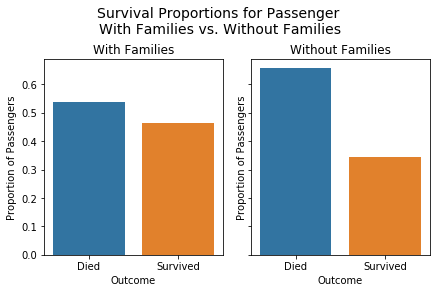

In [64]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, constrained_layout = True)

fig.suptitle('Survival Proportions for Passenger \nWith Families vs. Without Families', size = 14)

sns.barplot('index', y = 'proportion', data = fam_survival, ax = axs[0])
sns.barplot('index', y = 'proportion', data = single_survival,  ax = axs[1])

axs[0].set_title('With Families')
axs[0].set_xlabel('Outcome')
axs[0].set_ylabel('Proportion of Passengers')
axs[0].set_xticklabels(['Died', 'Survived'])


axs[1].set_title('Without Families')
axs[1].set_xlabel('Outcome')
axs[1].set_ylabel('Proportion of Passengers')
axs[1].set_xticklabels(['Died', 'Survived'])

It seems like individuals with families saw more survival outcomes that individuals without families. Let's investigate their death rates and see the resulting ratio.

In [65]:
fam_deaths = fam_survival.iloc[0, 1]/fam_survival.iloc[1,1]
print('Death Rate for Members of Families:', round(fam_deaths, 2))

singles_deaths = single_survival.iloc[0, 1]/single_survival.iloc[1,1]
print('Death Rate for Passengers without Family:', round(singles_deaths, 2))

Death Rate for Members of Families: 1.16
Death Rate for Passengers without Family: 1.91


Passengers with family aboard: 1.16 deaths for every survivor.

Passengers with no family aboard: 1.91 deaths for every survivor.

In [66]:
print('Family-less to Family-having Death Ratio:', str(round(singles_deaths/fam_deaths, 2)) + ':1')

Family-less to Family-having Death Ratio: 1.65:1


Individuals traveling without families (as operationalized) were 1.64 times more likely to die on the Titanic than individuals who WERE travelling with family.

This discrepancy seems more nuanced than the difference that was observed for gender. We should run an additional chi-square test followed by another measure of Phi. We will be reusing both as we are still dealing with categorical variables in a 2x2 table.

As the Parch column currently stands, data varies greatly. A parent may have 2, 3, or even 4 kids, but we wish to bucket these cases into one. So if an individual has a family, we will tag them with a corresponding binary indicator such as 0 or 1. This also helps control for outliers as there are likely very few cases of families with a Parch value of 5 or 6 for example. 

In [67]:
#assigning a binary indicator to denote if a passenger had family aboard
df['Parch_bin'] = sql('''
                      SELECT (CASE WHEN Parch = 0 THEN 0
                                   ELSE 1 END)
                      FROM df['Parch']
                      ''')

In [68]:
df.groupby(['Parch_bin', 'Survived']).size()

Parch_bin  Survived
0          0           445
           1           233
1          0           104
           1           109
dtype: int64

In [69]:
#filling the observations array
obs_parch = np.array([[445, 233], [104, 109]])

In [70]:
print('CHI-SQUARE FOR FAMILY MEMBERSHIP AND SURVIVAL OUTCOME')
print('\n')
chi_2x2(obs_parch)

CHI-SQUARE FOR FAMILY MEMBERSHIP AND SURVIVAL OUTCOME


Chi-Square Test Statistic: 18.656359965476746
P-Value: 1.5652427255789984e-05
Significant at Alpha = 0.05?: True


Expected Frequencies:
[[417.75757576 260.24242424]
 [131.24242424  81.75757576]]


Observed Frequencies:
[[445 233]
 [104 109]]


Phi Effect Size: 0.1447020235055325


Though our result is statistically significant, it seems like we only have a small effect size. This is still something to be considered and I will be including this in the final model. Additionally, now we have a new column, Parch_bin, that will likely be more useful in our final model than the potential outliers that less-common family sizes could introduce.

#### Age
Though no correlation was observed, we will analyze age to ensure we are not overlooking anything.

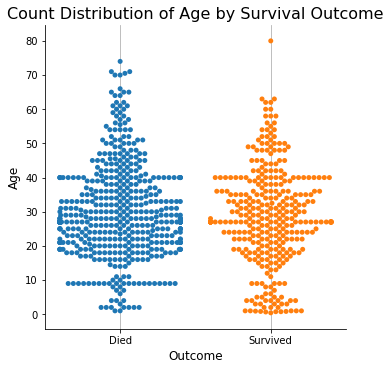

In [71]:
g = sns.catplot(x = 'Survived', y = 'Age', data = df, kind = 'swarm')

plt.title('Count Distribution of Age by Survival Outcome', size = 16)

g.set_xticklabels(['Died', 'Survived'])

plt.xlabel('Outcome', size = 12)
plt.ylabel('Age', size = 12)

plt.grid(axis = 'x')

It seems as though death did not discriminate by age on the Titanic. It does seem that children under 10 years old saw a few more survivals, and slightly more elderly folk died, but the vast majority appear to have a very similar distribution. To be certain, we can compare the two distributions to see if they differ significantly. To do this, I will isolate the age distributions of the dead and the survivors, and compare the two samples with a t-test.

C:\Users\BALTHASAR - 02\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


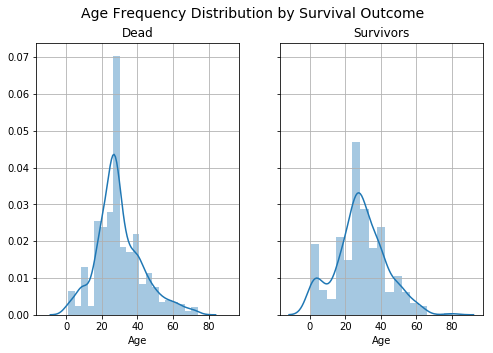

In [72]:
dead = df.loc[df['Survived'] == 0]
survived = df.loc[df['Survived'] == 1]

fig, axs = plt.subplots(1, 2, figsize = (8,5), sharex = True, sharey = True)

fig.suptitle('Age Frequency Distribution by Survival Outcome', size = 14)

sns.distplot(dead['Age'][:], ax = axs[0])
sns.distplot(survived['Age'][:], ax = axs[1])

axs[0].set_title('Dead')
axs[0].grid()

axs[1].set_title('Survivors')
axs[1].grid()

It appears as though there might be a small difference through this visualization. We can test this using a t-test. These distributions seem to resemble normal distributions, and the datatype is applicable, but it likely does not share equal variance so scaling is in order. We can just calculate the variance real quick to double-check.

In [73]:
print('Dead Age Variance', np.var(dead['Age']))
print('Survivor Age Variance', np.var(survived['Age']))

Dead Age Variance 171.50401292630107
Survivor Age Variance 199.20526786105114


To meet the final requirement for the t-test, we will have to scale the data to a variance of 1. This will get our distributions closer to normal, and be the last step needed for our t-test to give us the results we want to see.

In [74]:
#initializing scaler
SS = StandardScaler()

#scaling data
scaled_dead = SS.fit_transform(dead['Age'].values.reshape(-1,1))
scaled_survived = SS.fit_transform(survived['Age'].values.reshape(-1,1))

#unpacking scaled data (currently contained as a list of lists)
lst_dead = [val for item in scaled_dead for val in item]
lst_survived = [val for item in scaled_survived for val in item]  

In [75]:
print('Dead Age Variance:' , np.var(lst_dead))
print('Dead Age Mean:', np.mean(lst_dead))

print('Survivors Age Variance:' , np.var(lst_survived))
print('Survivors Age Mean:', np.mean(lst_survived))

Dead Age Variance: 1.0
Dead Age Mean: 8.412618911549456e-17
Survivors Age Variance: 0.9999999999999999
Survivors Age Mean: 1.1426856861639037e-16


In [76]:
#running t-test
t_stat, p_stat = ttest_ind(lst_dead, lst_survived)

#printing results
print('T-Statistic:', t_stat)
print('P-Value', p_stat)
print('Significant at Alpha = 0.05?:', p_stat < 0.05)

T-Statistic: -4.370689303125006e-16
P-Value 0.9999999999999997
Significant at Alpha = 0.05?: False


Our t-test indicates that the two age distributions don't differ much at all. We shouldn't observe any meaningful differences in survival outcomes based on age. Given that, we can safely exclude age from our set of features.

#### Sibling/Spouse
The last feature to check is if a passenger had a sibling or spouse onboard. This seems like something that is better predicted by our Parch_bin feature, but we should check if differences exist, just to be sure.

In [77]:
#getting survival proportions for sibling/sposue count
total_sibsp = (df['SibSp'].groupby(df['Survived'])
                          .value_counts(normalize = True)
                          .rename('proportion')
                          .reset_index())

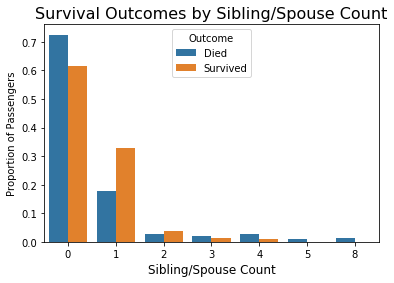

In [78]:
plt.title('Survival Outcomes by Sibling/Spouse Count', size = 16)

g = sns.barplot(x = 'SibSp', y = 'proportion', data = total_sibsp, hue = 'Survived')

plt.xlabel('Sibling/Spouse Count', size = 12)
plt.ylabel('Proportion of Passengers')

h, l = g.get_legend_handles_labels()

plt.legend(h, ['Died', 'Survived'], title = 'Outcome')

The distributions do seem to differ very slightly, to be sure we can run a chi square test once more to see if this is a difference worth including. This likely has no effect. Again, we will be converting the SibSp column to a binary outcomes because we only care about if a passenger had siblings/a spouse onboard or not, not necessarily how many.

In [79]:
#sql to assign binary indicator, denoting if a passenger had a sibling or spouse onboard the ship
df['SibSp_bin'] = sql('''
                      SELECT (CASE WHEN SibSp = 0 THEN 0
                                   ELSE 1 END)
                      FROM df['SibSp']
                      ''')

In [80]:
#displaying values
df.groupby(['SibSp_bin', 'Survived']).size()

SibSp_bin  Survived
0          0           398
           1           210
1          0           151
           1           132
dtype: int64

In [81]:
#assigning values to an array
obs_sibsp = np.array([[398, 210], [151,132]])

print('CHI SQUARE FOR SIBLING/SPOUSE AND SURVIVAL OUTCOME')
print('\n')
chi_2x2(obs_sibsp)

CHI SQUARE FOR SIBLING/SPOUSE AND SURVIVAL OUTCOME


Chi-Square Test Statistic: 11.45562814125045
P-Value: 0.0007127779147796147
Significant at Alpha = 0.05?: True


Expected Frequencies:
[[374.62626263 233.37373737]
 [174.37373737 108.62626263]]


Observed Frequencies:
[[398 210]
 [151 132]]


Phi Effect Size: 0.11338891557045129


There appears to be a small effect in survival rate depending on if a passenger had a sibling or spouse onboard the ship. Though this feature is very related to the Parch column, it does account for the case for siblings or spouses travelling without any children or parents. 

I think including this feature gives an added layer of complexity that may be useful as it accounts for cases where an individual was not travelling with family, but perhaps had a spouse or a sibling. Having such a relationship on board the ship could increase ones likelihood of survival in the sense that now they aren't working through the crisis alone. More help with getting through obstacles or calling for help may help explain the slightly better outcomes.

#### Summary of EDA

We have identified passenger class, family-membership, and gender as useful features tha were highly predictive of survival outcomes. These features will be included in our model selection process, but all other features will be dropped as we no longer need them.

In [82]:
#dropping unneeded columns
#sibsp and parch have been converted to binary outcomes
df.drop(columns = ['SibSp', 'Parch', 'Embarked', 'Age'], inplace = True)

### Model

There are a couple different models that I believe would be appropriate here. Given the nature of our categorical outcomes, Naive-Bayes, Random Forest, and Logistic Regression are most appropriate. Another suitable alternative is XGBoost but that seems overly complex and taxing for getting the results we want.

We will test all three models and compare them using a confusion matrix, and deriving our metrics from there. In a real-world scenario, we would want a model that could properly predict who was at most risk of death, so we would want good precision (proportion of correct true positives over all positives) and recall (proportion of true positives over true positives plus false negatives). Along with that, we should also be calculating F1 score as it tells us more about the accuracy of the test than a standard accuracy measure would.

![](https://miro.medium.com/max/1050/1*j-AAfRjIzhjCnGFdbMoyTQ.jpeg_)

We've identified sex, class, if the passenger had siblings or a spouse aboard the ship, and whether or not the individual was travelling with family (children or a parent) as useful predictors for survival.

In [83]:
#reading in test data
test = pd.read_csv('test.csv')

In [84]:
#quick clean of the test data
test['Parch_bin'] = sql('''SELECT (CASE WHEN Parch == 0 THEN 0 ELSE 1 END)
                                              
                            FROM test['Parch']''')

test['SibSp_bin'] = sql('''SELECT (CASE WHEN SibSp == 0 THEN 0 ELSE 1 END)
                                              
                            FROM test['SibSp']''')

#converting sex column to binary for compatibility with models
# 0 = Male, 1 = Female
test['Sex'] = pd.get_dummies(test['Sex'])

In [85]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Parch_bin,SibSp_bin
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,1,1


In [86]:
#converting sex column to binary for compatibility with models
# 0 = Male, 1 = Female
df['Sex'] = pd.get_dummies(df['Sex'])
df.head()

,Survived,Pclass,Sex,Parch_bin,SibSp_bin
0,0,3,0,0,1
1,1,1,1,0,1
2,1,3,1,0,0
3,1,1,1,0,1
4,0,3,0,0,0


In [87]:
#feature space
X = df[['Pclass', 'Sex', 'Parch_bin', 'SibSp_bin']]

#target
y = df['Survived']

#creating training, validation, and test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

#relevant columns for test feature space
X_test = test[['Pclass', 'Sex', 'Parch_bin', 'SibSp_bin']]

In [88]:
def mod(mod):
    
    #fits inputted model
    model = mod.fit(X_train, y_train)
    
    #predicts validation labels
    y_val_pred = model.predict(X_val)
    
    #plots a confusion matrix of predicted and actual outcomes
    cm = confusion_matrix(y_val_pred, y_val)
    
    #present confusion matrix as a heatmap
    sns.heatmap(cm, 
            annot = True,
            annot_kws = {"size": 16},
            yticklabels = ['Negative', 'Positive'],
            xticklabels = ['Neg. (Pred)', 'Pos. (Pred)'],
            cmap = 'OrRd',
               fmt = 'g')
    
    #getting counts True Negatives, False Positives, False Negatives, ad True Positives
    tn, fp, fn, tp = cm.ravel()
    
    #model scoring metrics
    score = model.score(X_val, y_val)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = 2*((precision * recall)/ (precision + recall))
    
    #print results
    print('PRECISION:', precision)
    print('RECALL:', recall)
    print('F1-SCORE:', f1)
    print('ACCURACY:', score)

#### Logistic Regression
Using a sigmoid function, the logistic regression model will return a value within 0 and 1, leading to a binary prediction denoting what class a particular record belongs to. This model is simple yet powerful.

PRECISION: 0.6805555555555556
RECALL: 0.7424242424242424
F1-SCORE: 0.7101449275362319
ACCURACY: 0.776536312849162


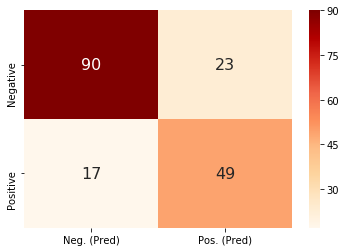

In [89]:
LR = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 20)
mod(LR)

90 true negative, 23 false positive, 17 false negative and 49 true positive.

Our precision seems to be bringing down our f1 score, meaning we're getting a lot of false positives. This isn't terrible, becuase being told you're going to die when in reality you wont has little consequences other than added stress. It is the opposite condition that we must be afraid of (false negatives). Our recall score, which measures false negatives, is a bit better but we should aim higher. The overall score seems alright, but again, we can do better.

#### Categorical Naive Bayes
A version of the Naive Bayes classifier that works best with categorical data. In our case this is really useful as we are searhcing for binary outcomes. The model works by using Bayesian probability to both calculate priors and determine the probability that a given record belongs to a certain class. The class with the highest probability is assigned.

PRECISION: 0.7083333333333334
RECALL: 0.7285714285714285
F1-SCORE: 0.7183098591549296
ACCURACY: 0.776536312849162


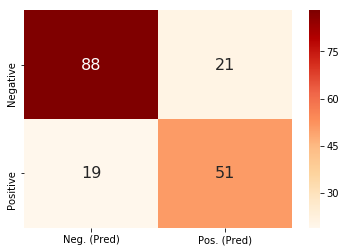

In [90]:
CNB = CategoricalNB()
mod(CNB)

The CNB performs better in recall and precision, leading to a better F1-score. Overall accuracy is about the same.

#### Random Forest Classifier
The most complex of the three models. The RFC creates decision trees that each create splits based on how much information can be gained by a split. At the end, a vote is taken between all of the estimators and the recrd is classified with the majority vote.

PRECISION: 0.6388888888888888
RECALL: 0.7419354838709677
F1-SCORE: 0.6865671641791045
ACCURACY: 0.7653631284916201


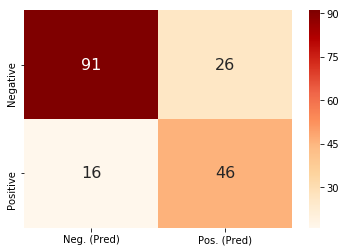

In [91]:
RFC = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 33)
mod(RFC)

The RFC performs marginally better than the CNB in recall, but is outclassed in every other category.

### Model Decision

The Random Forest Classifier and Categorical Naive Bayes performed better than the Logistic Regression all-around. Though the CNB had the best precision, the RFC came out on top with the best recall, F1 score, and accuracy.

It is important to maximize recall for this problem because we want to ensure that people we predict to die get accurately classified. In a real-world situation we would rather over-estimate the deaths than over-estimate the survivors. Additionally, we should be considering overall computational efficiency of the model. The RFC is an expensive and complicated model to run on larger datasets. While it did achieve the highest recall score, its precision, accuracy, and F1 score were beaten by the scores of the Categorical Naive Bayes model. On top of this, the CNB is less computationally taxing, so it wins in that regard as well.

For these reason, the CNB will be selected as our primary model. While the RFC scored the highest recall score, it was only a marginal increase and not worth the potential resource expenditure considering it performed so poorly in every other metric too.


In [94]:
#Fitting model with the Categorical Naive Bayes
model = CNB.fit(X_train, y_train)

#predicting outcomes
y_test_pred = model.predict(X_test)

#assigning predictions to the test set
test['Survived'] = y_test_pred

In [95]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Parch_bin,SibSp_bin,Survived
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,1,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,0,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,1,1,1


## Conclusion
In this notebook we have identified several discrepancies in passenger attributes that led to better survival outcomes on the Titanic. These features have aided us in building a model that can predict which passengers are likely to have died during the disaster. We opted for a measure of recall above all other metrics, but went with a model that maximized recall while not compromizing accuracy, and precision.